In [3]:
import dimod
from dwave.embedding import verify_embedding
from dwave.system import DWaveSampler, EmbeddingComposite, TilingComposite,FixedEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler 
from dimod.serialization.format import Formatter
from datetime import datetime
from dwave_networkx import pegasus_graph
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math as m
from minorminer import find_embedding, layout, busclique
import networkx as nx
from numpy import kron
from collections import defaultdict

In [4]:
couplingsPth = "C:/Users/cicer/Documents/ThesisWork/Ocean/Couplings"
hamiltoniansPth = "C:/Users/cicer/Documents/ThesisWork/Ocean/Hamiltonians"
notebookOutputsPth = "C:/Users/cicer/Documents/ThesisWork/Ocean/NotebookOutputs"
schedPath = "C:/Users/cicer/Documents/ThesisWork/Ocean/AnnealingSchedules"

In [5]:
def returnAB(s):
    """
    Given a value for s, return the corresponding A and B value from the annealing schedule
    precision of s is limited to scale of 1e-3
    """
    ind = np.where(A[:,0]==s)
    return [A[ind][0][1],B[ind][0][1]]

In [6]:
def def1DCouplings(L):
    """
    Method for defining nearest neighbours couplings of a line of L qubits randomly assigning
    the couplings a +/- 1 or random output based on a Gaussian spread. Does not have PBC

    Outputs:
    [J_dict, J_matrix]
    J_dict: Formatted dictionary of couplings to be used in dwave's Sampler.sample_ising() functions
    J_matrix: Coupling matrix output to be used later for lowest energy state calculations using the findLowest(L,J) function
    """

    J_matrix = []
    J_dict = {}
    for i in range(L-1):
        # j_i = random.randrange(-1,2,2)
        j_i = random.uniform(-1,1)
        row = np.zeros(shape = L)
        row[i+1] = 1
        # print(row)
        J_matrix.append(row)
        key = (i,i+1)
        J_dict.update({key:j_i})
    
    J_matrix.append(np.zeros(shape=L))

    
    return J_dict, np.array(J_matrix)

In [7]:
def defCouplings(L, PBC):
    """
    Method for finding nearest neighbours couplings of an LxL lattice 
    and randomly assigning the couplings a +1 or -1 value

    Args:
    L: Side length of the system, system is defined as an LxL system
    PBC: Indicate whether to include periodic boundary conditions or not, currently does nothing
    
    Outputs:
    [J_dict, J_matrix]
    J_dict: Formatted dictionary of couplings to be used in dwave's Sampler.sample_ising() functions
    J_matrix: Coupling matrix output to be used later for lowest energy state calculations using the findLowest(L,J) function
    """
    J_matrix = []
    J_dict = {}
    for i in range(L*L):
        row = np.zeros(shape = L*L)
        
        if(i <L*(L-1)): # Add coupling to South neighbour
            try:
                row[i+L] = 1
            except IndexError:
                pass
        if(i%L!=(L-1)): # Add coupling to East neighbour, unless east-edge site
            row[i+1] = 1
        if(i%L==0): # Add coupling to "West" neighbour for west-edge sites
            row[i+L-1] = 1
        if(i<L):
            row[i+L*(L-1)] = 1
        # print(row)
        J_matrix.append(row)
    J_matrix = np.array(J_matrix)
    # By default only creates an upper triangular matrix, if working with QUBOs leave as is, if working in Ising model use a square matrix
    # J_matrix = J_matrix + J_matrix.T
    ij = np.where(J_matrix == 1)
    coupls = tuple(zip(*ij))

    for i in coupls:
        # j_i = random.randrange(-1,2,2)
        j_i = random.uniform(-1,1)
        # j_i = 1
        J_dict.update({i:j_i})
        J_matrix[i[0]][i[1]] = j_i         
    
    return J_dict, J_matrix

In [8]:
def findLowest(L, J):
    """
    Find lowest energy of a spin configuration given some coupling matrix

    Args:
    L: Length and Width of 2-D square Ising model (i.e. 3x3 model, L=3)
    J: Coupling matrix

    Outputs: [minEnergy, minState, degenerateStates]
    minEnergy: Energy of minimum energy state
    array minState: Integer number representing state configuration of minimum energy state
    array degenerateStates: Integer number(s) representing degenerate ground state configurations
    """
    # Add back J
    numSpins = L*L
    numStates = 2**numSpins
    minState = None
    minEnergy = 10**10
    degenerateStates = []
    
    for i in range(numStates):
        s = numToState(i, numSpins)
                
        # Calculate energy of state 
        currEnergy = np.dot(s, np.dot(J,s))

        # Switch if necessary, raise degenerate ground state flag if applicable
        if(currEnergy < minEnergy):
            minEnergy = currEnergy
            # minState = s.copy()
            minState = i
            degenerateStates = [] # If a new lower state is found, formerly degenerate ground states just become degenerate states and are no longer of interest
        elif (abs(currEnergy - minEnergy) < 1e-10 ):
            degenerateStates.append(i)

    # degenerateStates = np.insert(degenerateStates, 0, minState, axis=0)

    return minEnergy, minState, degenerateStates

In [9]:
def numToState(i, numSpins):
    """
    Given a number and the number of states for a spin configuration convert the number to a binary number then a spin configuration with 1 -> +1 and 0 -> -1 spins

    Args:
    i: Number to convert
    numStates: Number of states to look at

    Output:
    s: Spin Configuration as an array with each spin a separate index
    """
    s = np.zeros(numSpins, dtype=int)

    for j in range(numSpins):
        if( (i & (1 << j)) != 0):
            s[j] = 1
        else:
            s[j] = -1

    return s

In [10]:
def dictToArr(statesDict):
    """
    Given a dictionary of site values, with the site index and site value, convert it to an array

    Args:
    dict: Dictionary of sites to convert to array

    Output:
    arr - Array of site values
    """
    arr = []
    for i in statesDict:
        arr.append(statesDict[i])

    return np.array(arr)

In [11]:
def validation(stateArr, degenStates):
    """
    Given a state returned from DWave sampler, and degenerate ground states found check that the state array is found among the degenerate states

    Args:
    stateArr: state returned from the DWave sampler
    degenStates: degenerate states found by the findLowest() method

    Output:
    None - prints out if the state is found
    """
    L = len(stateArr)
    for i in range(len(degenStates)):
        print(stateArr)
        print(degenStates[i])
        print(L)
        temp = np.all(stateArr == numToState(degenStates[i],L*L))
        if(temp):
            print("Passed; index  " +str(i) + "of groundStates")

In [12]:
def saveJ(J_dict,L, dims):
    """
    Given a coupling dictionary, one length measurement of the system, and the number of 
    dimensions in the system (1 or 2), save a file using these couplings in such a way
    that they can be submitted to the McGroundstate server provided by University of Bonn

    Args:
    J_dict: Dictionary of all the couplings defined by DWaves standards to be submitted to their Leap service
    L: Length of one side of the system: for 1-D system the length of the system; for 2-D system, the length of one side
    dims: Number of dimensions of the system: 1-D: dims = 1; 2-D: dims = 2.

    Output:
    filename: Filename the file was saved to without the extension 
    """
    
    shape = 'u'
    timestamp = datetime.now().strftime("%Y-%m-%d_%H\'%M\'%S")
    filename = f"{couplingsPth}/Couplings_L={L}_{shape}_{timestamp}.sg"
    nspins = L**dims
    ninter = len(J_dict)
    with open(filename, "w") as file:
        file.write(f"# {filename[52:-3]}\n")
        file.write(f"{nspins} {ninter}\n")
        for (i,j), Jij in J_dict.items():
            if Jij < 0:
                file.write(f"{i+1} {j+1} {-Jij:0.5f}\n")
            else:
                file.write(f"{i+1} {j+1} {-Jij:0.5f}\n")

    print(f"Couplings saved at: {filename}")
    return filename[62:-3] # Return run's unique identifier string

In [13]:
def singleSpinTerm(N, s, pauli, c=1.0):
    """
    Function for calculating the contribution to the Hamiltonian from a single spin, used to reduce this calculation to one line in other code

    Args:
        N (int) - Number of spins in state
        s (int) - spin index for which the contribution comes from
        pauli (nd.array) - Pauli matrix that will be used in calculations, will be either Pauli-x or Pauli-y matrix in this case
        c (float, optional) - Constant to multiply term by

    Return:
        nd.array - Contribution to Hamiltonian matrix from the particular spin
    """
    sigma = 1.0
    for j in range(N):
        if j == s: # When reached qubit index, work with Pauli_x matrix
            if j != 0: #  
                sigma = np.kron(sigma, pauli) 
            else :
                sigma = pauli
        else: # Otherwise work with identity matrix
            if j != 0:
                sigma = np.kron(sigma, I) 
            else:
                sigma = I

    return c*sigma

In [14]:
def coupledSpinsTerm(N, s1, s2, J_12=1.0):
    """
    Function for calculating the contribution to the Hamiltonian from a single spin, used to reduce this calculation to one line in other code

    Args:
        N (int) - Number of spins in state
        s1 (int) - spin index of one coupled spin
        s2 (int) - spin index of second coupled spin
        c (float, optional) - Constant to multiply term by

    Return:
        nd.array - Contribution to Hamiltonian matrix from the particular spin
    """
    p_z = np.array([[1,0],[0,-1]])
    I = np.array([[1,0],[0,1]])
    sigma = 1.0
    for j in range(N):
        if j == s1 or j == s2: # When reached qubit index, work with Pauli_x matrix
            if j != 0: #  
                sigma = np.kron(sigma, p_z) 
                # print("Took tensor product with pauli matrix")
            else :
                sigma = p_z
        else: # Otherwise work with identity matrix
            if j != 0:
                sigma = np.kron(sigma, I) 
                # print("Took tensor product with identity matrix")
            else:
                sigma = I
        # print(sigma)

    return J_12*sigma

In [15]:
def defHamiltonian(A, B, J_matrix):
    """
    Define Hamiltonian given the A(s) and B(s) values paused at along with the coupling matrix

    A (float): Strength of transverse field taken from the annealing schedule excel sheet provided by DWave

    B (float): Strength of classical problem Hamiltonian also taken from annealing schedule excel sheet provided by DWave

    J_matrix (nd.array): 2 dimensional Numpy array of spin interaction couplings
    """
    shape = 'u'
    timestamp = datetime.now().strftime("%Y-%m-%d_%H\'%M\'%S")
    filename = f"{hamiltoniansPth}/Hamiltonian_L={L}_{shape}_{timestamp}.csv"
    n = len(J_matrix)    
    # N = int(np.log2(n))
    
    # Calculate transverse field term
    Hdim = 2**n
    datatype = np.float16
    H_trans = np.zeros((Hdim, Hdim), dtype = datatype)
    H_coup = np.zeros((Hdim, Hdim), dtype = datatype)
    H = np.zeros((Hdim, Hdim), dtype = datatype)

    print(f"Defining {Hdim}x{Hdim} (2**{n}x2**{n}) Hamiltonian")
    
    # Adding the x-spin contributions from each qubit
    for s in range(n):
        # Calculate contribution and add to Hamiltonian
        contribution = singleSpinTerm(n, s, p_x, A)
        H_trans -= contribution

    # Adding the coupled spins
    for i in range(len(J_matrix)):
        for j in range(len(J_matrix[0])):
            if(J_matrix[i][j] != 0):
                contribution = coupledSpinsTerm(n, i, j, J_matrix[i][j])
            H_coup -= B*contribution

    # Contributions due to linear biasing is forgon as 
    # for now there is no need but should the need arise 
    # in the future the proper amendments can be made 

    H = H_trans + H_coup

    np.savetxt(filename, H, fmt='%.6f', delimiter=',', header=filename[27:-3])
    print(f"Hamiltonian saved at {filename}")

In [16]:
def returnServerCoupls(J_coupls):
    """
    Originally designed to work together with the saveJ() function to conveniently
    save couplings in a way the validation server could work with them but no longer needed

    Args:
    J_coupls: Input dictionary containing couplings of system

    Outputs:
    srv_coupls: Same input dictionary with keys incremented so indices start from 1, not 0
    """
    
    srv_coupls = {}

    for i in J_coupls.keys():
        key = (i[0]+1,i[1]+1)
        # print(key)
        srv_coupls[key] = J_coupls[i]
        
    return srv_coupls

In [17]:
def flipRand(state):
    """
    Given a state return the state with randomly flipped states.
    Used to get a random starting state for reverse annealing after finding
    the ground state in a forward annealing run.

    Args:
    state: Ground state array of current system

    Output:
    state: State of semi random bits for qubit
    """
    for i in state.keys():
        state[i] *= (-1)**i
        
    return state

In [18]:
def optimizeEndpoint(tf, maxSlope, sp, epsilon = 1e3):
    """
    Find last possible time before starting final 'quench' annealing step, to
    minimize time spent by the system moving out of the state of interest. The
    slope cannot be larger so this iterative method gets as close as possible
    within tolerance

    Args:
    tf: Final time, the total elapsed time of the annealing schedule in microseconds
    maxSlope: Maximum rate of change of s wrt t (ds/dt), defined as the inverse of the 
              minimum annealing time of the sampler, defined by the sampler
    sp: Pause point of annealing progress
    epsilon: Tolerance for how close the found value should be to the max value

    Output:
    tp_end: Time to define end of pause period, maximizing change of s
    """
    tp_end = None
    checkSlope = True
    
    while(checkSlope):
        tp_end = tf+(sp-1.0)/maxSlope
        slope = (1.0-sp)/(tf-tp_end)
        diff = maxSlope-slope
        if(abs(diff) < epsilon):
            checkSlope=False
        else:
            tp_end += (diff/abs(diff))*0.01
    
    return tp_end

In [19]:
def recToArrs(record):
    energy_occurrences = defaultdict(int)

    for _, energy, occurrences, _ in record:
        energy_occurrences[energy] += occurrences
    
    energies = []
    occurrences = []
    for energy, occurrence in sorted(energy_occurrences.items()):
        energies.append(energy)
        occurrences.append(occurrence)

    return [values, occurrences]

In [ ]:
def hv(x, J, s):
    

In [93]:
print(J_matrix)

NameError: name 'J_matrix' is not defined

In [ ]:
def JtoH(J,s):
    

In [ ]:
print(JtoH(

In [50]:
def trunc3(i):
    return m.trunc(i*1000)/1000

In [67]:
def BITVAL(i,a):
    return int(bool(i&1<<a))

In [62]:
def BITFLIP(i,a):
    return i^1<<a

**-------------------------------------------------- End of helper function definitions ----------------------------------------------**

In [91]:
int(m.log2(L))

3

In [92]:
L = 8
for i in range(L):
    print(f"{i}: ", end="")
    for a in range(int(m.log2(L))):
        print(f"{BITFLIP(i,a)}, ", end="")
    print()

0: 1, 2, 4, 
1: 0, 3, 5, 
2: 3, 0, 6, 
3: 2, 1, 7, 
4: 5, 6, 0, 
5: 4, 7, 1, 
6: 7, 4, 2, 
7: 6, 5, 3, 


In [95]:
# Defining matrices to use
Sx = 1/2*np.array([[0,1],
                   [1,0]])
Sz = 1/2*np.array([[1,0],
                   [0,-1]])
Sy = 1/2*np.array([[0, 1.j],
                   [-1.j, 0]], dtype=np.complex_)
I = np.array([[1,0],
              [0,1]])

# Getting A(s) and B(s) values in the program
test = pd.read_excel("09-1263A-B_Advantage_system4_1_annealing_schedule.xlsx", 1,
                     usecols = "A:C", 
                     names = ["s","A","B"],
                     )
A = test[["s","A"]].to_numpy()
A = {trunc3(row[0]): row[1] for row in A}
B = test[["s","B"]].to_numpy()
B = {trunc3(row[0]): row[1] for row in B}

In [96]:
sampler = DWaveSampler()
samplerEC = EmbeddingComposite(sampler)

# print(qpu.properties["annealing_time_range"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))
print("Connected to sampler:", sampler.solver.name)
min_anneal = sampler.properties["annealing_time_range"][0]
print(f"Minimum annealing time is: {min_anneal}")
max_slope = 1/min_anneal
print(f"The maximum slope for the annealing schedule can be: {max_slope}")

SolverAuthenticationError: Invalid token or access denied

In [61]:
L = 3
J_coupls, J_matrix = def1DCouplings(L)
runID = saveJ(J_coupls,L, dims=1)
h = {}

sampler_edgelist = sampler.edgelist
embedding = find_embedding(J_coupls.keys(), sampler_edgelist)
source = nx.Graph()
source.add_edges_from(J_coupls.keys())
target = sampler.to_networkx_graph()
validEmbedding = verify_embedding(emb=embedding, source=source, target=target)
embeddedSampler = FixedEmbeddingComposite(sampler, embedding)
initStateSampled = embeddedSampler.sample_ising(h, J_coupls, num_reads=100)
initRecord = initStateSampled.record

energies = []
for i in initRecord:
    energies.append(i[1])

energies = np.array(energies)
values, counts = np.unique(energies, return_counts = 1)
# print(values)
# print(counts)
print(initRecord)

energy_occurrences = defaultdict(int)

for _, energy, occurrences, _ in initRecord:
    energy_occurrences[energy] += occurrences

energies = []
occurrences = []
for energy, occurrence in sorted(energy_occurrences.items()):
    energies.append(energy)
    occurrences.append(occurrence)

print(energies)
print(occurrences)
plt.scatter(energies, occurrences)

Couplings saved at: C:/Users/cicer/Documents/ThesisWork/Ocean/Couplings/Couplings_L=3_u_2025-01-23_20'34'50.sg


SolverAuthenticationError: Invalid token or access denied

[([-1,  1,  1, -1,  1, -1], -2.90877448, 22, 0.)
 ([ 1, -1, -1,  1, -1,  1], -2.90877448, 38, 0.)
 ([-1,  1,  1, -1,  1,  1], -2.83344285, 11, 0.)
 ([ 1, -1, -1,  1, -1, -1], -2.83344285, 28, 0.)
 ([-1, -1, -1,  1, -1,  1], -2.04960354,  1, 0.)]
[-2.9087744825371287, -2.8334428545051855, -2.049603536751475]
[60, 39, 1]


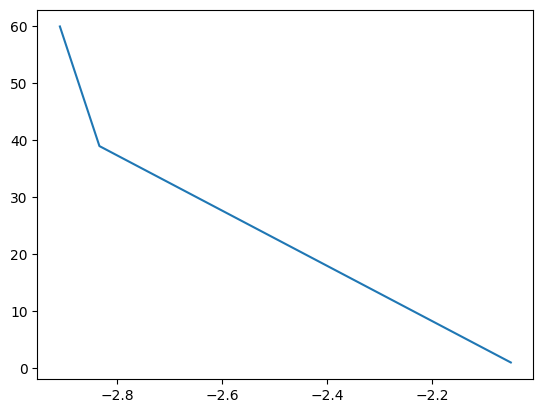

In [45]:
# print(values)
# print(counts)
print(initRecord)

energy_occurrences = defaultdict(int)

for _, energy, occurrences, _ in initRecord:
    energy_occurrences[energy] += occurrences

energies = []
occurrences = []
for energy, occurrence in sorted(energy_occurrences.items()):
    energies.append(energy)
    occurrences.append(occurrence)

print(energies)
print(occurrences)
plt.scatter(energies, occurrences)

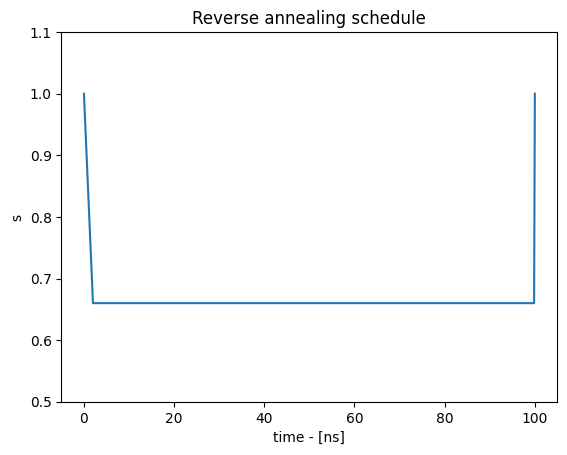

In [60]:
t, s = zip(*reverse_schedule)
plt.clf()
plt.plot(t,s)
plt.title("Reverse annealing schedule")
plt.xlabel("time - [ns]")
plt.ylabel("s")
plt.ylim([0.5,1.1])
plt.show()


Couplings saved at: C:/Users/cicer/Documents/ThesisWork/Ocean/Couplings/Couplings_L=6_u_2025-01-22_15'15'08.sg


<Figure size 640x480 with 0 Axes>

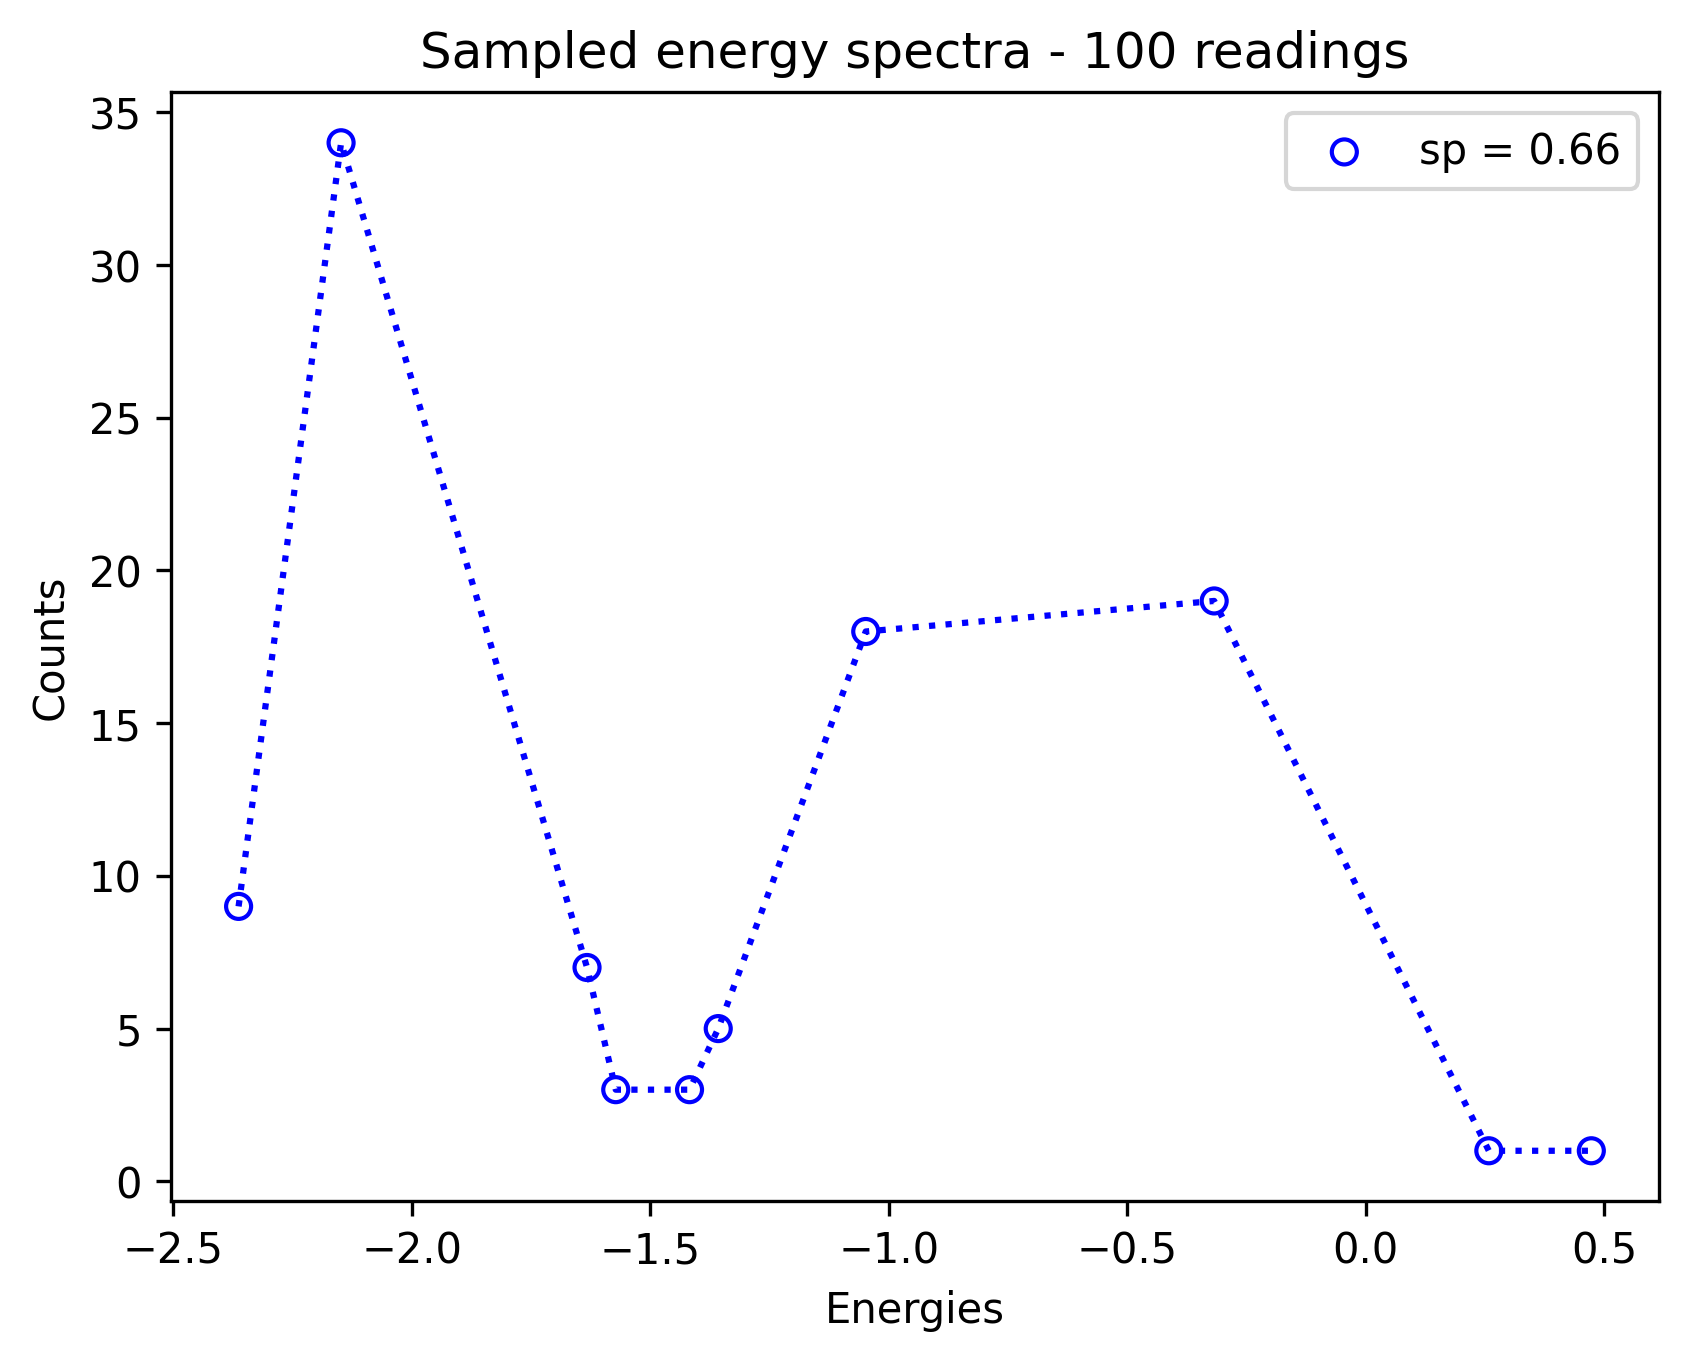

In [59]:
L = 6
J_coupls, J_matrix = def1DCouplings(L)
runID = saveJ(J_coupls,L, dims=1)
h = {}

# Get initial state
sampler_edgelist = sampler.edgelist
embedding = find_embedding(J_coupls.keys(), sampler_edgelist)
source = nx.Graph()
source.add_edges_from(J_coupls.keys())
target = sampler.to_networkx_graph()
validEmbedding = verify_embedding(emb=embedding, source=source, target=target)
embeddedSampler = FixedEmbeddingComposite(sampler, embedding)
initStateSampled = embeddedSampler.sample_ising(h, J_coupls, num_reads=100)
initRecord = initStateSampled.record


initState = initStateSampled.first.sample
initState = flipRand(initState)

# Define variables for standard annealing
# sp_list = [0.1, 0.2, 0.278, 0.4, 0.5, 0.65, 0.7, 0.8, 0.9]
# sp_list = [0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74]
# sp_list = [0.66, 0.68, 0.70, 0.72, 0.74, 0.76]
# sp_list = [0.64, 0.66, 0.68, 0.70]
sp_list = [0]
spectra = []
energySpectrum = []

for sp in sp_list:
    tf = 100 # 100 microseconds schedule
    # tp_end =  round(tf-(1.0-sp)/1.97,2) # Calculating near latest time available to quench
    tp_end = optimizeEndpoint(tf, max_slope, sp)
    pnq_schedule = [[0.0, 0.0], [2.0, sp], [tp_end, sp], [tf, 1.0]]
    reverse_schedule = [[0.0, 1.0], [2.0, sp], [tp_end, sp], [tf, 1.0]]
    numReads = 100
    
    # Do reverse annealing
    revAnneal = embeddedSampler.sample_ising(h, J_coupls, 
                                             num_reads = numReads,
                                             anneal_schedule = reverse_schedule,
                                             initial_state = initState,
                                             reinitialize_state = True)
    record = revAnneal.record
    
    energies = []
    for i in record:
        energies.append(i[1])
    
    energies = np.array(energies)

    # print(f"--------------- Reverse annealing results - sp = {sp} ---------------")
    values, counts = np.unique(energies, return_counts = 1)
    # f.write(values)
    if(len(energySpectrum)<len(values)):
        energySpectrum = values.copy()
    # print(values)
    # f.write(counts)
    # print(counts)
    spectrum = [values, counts]
    spectra.append(spectrum)

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'P', 'X']
colours = ['blue','orange','green','red','purple','brown','pink','cyan','magenta']
# print(f"The total list of sampled energies are:\n{energySpectrum}")
plt.clf()
fig, ax = plt.subplots(dpi = 300)
for i in range(len(spectra)):
    values = spectra[i][0] 
    counts = spectra[i][1]
    plt.scatter(values, counts, label = f"sp = {sp_list[i]}", marker=markers[i], facecolors='none', edgecolors=colours[i])
    plt.plot(values, counts, linestyle=':', color=colours[i])
# ax.set_title(f"Sampled energy spectra with varying sp - {numReads} readings per run")
ax.set_title(f"Sampled energy spectra - {numReads} readings")
ax.set_ylabel("Counts")
ax.set_xlabel("Energies")
plt.legend()
figPath = notebookOutputsPth +"/Spectrum_"+ runID +".png"
plt.savefig(figPath)
plt.show()
plt.close()

In [38]:
print(energySpectrum)
for i in range(len(spectra)):
    print(f"sp = {sp_list[i]}: spectrum - ({spectra[i][0]} {spectra[i][1]})")

[-2.13418979 -1.85642074 -1.3148059  -1.03703685 -0.61269686 -0.48445607
 -0.20668702  0.20668702  1.03703685  1.85642074]
sp = 0.1: spectrum - ([-2.13418979 -1.85642074] [37 13])
sp = 0.2: spectrum - ([-2.13418979 -1.85642074] [36 14])
sp = 0.278: spectrum - ([-2.13418979 -1.85642074 -1.3148059 ] [41  7  2])
sp = 0.4: spectrum - ([-2.13418979 -1.85642074 -1.3148059 ] [45  4  1])
sp = 0.5: spectrum - ([-2.13418979 -1.85642074 -1.03703685] [42  7  1])
sp = 0.65: spectrum - ([-2.13418979 -1.85642074 -1.3148059  -1.03703685 -0.61269686 -0.48445607
 -0.20668702  0.20668702  1.03703685  1.85642074] [18  2 10  1  9  3  1  3  2  1])
sp = 0.7: spectrum - ([-1.3148059  -1.03703685 -0.61269686 -0.20668702  1.03703685  1.3148059
  1.85642074  2.13418979] [ 2  2  3  1  2  4 20 16])
sp = 0.8: spectrum - ([2.13418979] [50])
sp = 0.9: spectrum - ([2.13418979] [50])


In [ ]:
L = 5
J_coupls, J_matrix = def1DCouplings(L)
saveJ(J_coupls,L, dims=1)
h = {}

sampler_edgelist = sampler.edgelist
embedding = find_embedding(J_coupls.keys(), sampler_edgelist)
source = nx.Graph()
source.add_edges_from(J_coupls.keys())
target = sampler.to_networkx_graph()
validEmbedding = verify_embedding(emb=embedding, source=source, target=target)
embeddedSampler = FixedEmbeddingComposite(sampler, embedding)
initStateSampled = embeddedSampler.sample_ising(h, J_coupls, num_reads=100)

initState = initStateSampled.first.sample
initState = initStateSampled.record[0]["sample"]
initState = initStateSampled.first.sample
initState = flipRand(initState)

sp = 0.278
tf = 100 # 100 microseconds schedule
# tp_end =  round(tf-(1.0-sp)/1.97,2) # Calculating near latest time available to quench
tp_end = optimizeEndpoint(tf, maxSlope, sp)
pnq_schedule = [[0.0, 0.0], [2.0, sp], [tp_end, sp], [tf, 1.0]]
reverse_schedule = [[0.0, 1.0], [2.0, sp], [tp_end, sp], [tf, 1.0]]
numReads=1000

revAnneal = embeddedSampler.sample_ising(h, J_coupls, 
                                         num_reads = numReads,
                                         anneal_schedule = reverse_schedule,
                                         initial_state = initState,
                                         reinitialize_state = True)
record = revAnneal.record

energies = []
for i in record:
    energies.append(i[1])

energies = np.array(energies)

print("Reverse annealing results")
values, counts = np.unique(energies, return_counts = 1)
print(values)
print(counts)

plt.clf()
plt.scatter(values, counts)
plt.title(f"Energy occurances - A state read {numReads} times - Reverse Annealing")
plt.ylabel("Counts")
plt.xlabel("Energy sampled")
plt.show()


# ----------------- Standard Annealing run for comparision ------------------------------------------------------
stdAnneal = embeddedSampler.sample_ising(h, J_coupls,
                                         num_reads = 1000)
tempNrgs = []
tempCounts = []
for i in stdAnneal.record:
    tempNrgs.append(i[1])
    tempCounts.append(i[2])

stdNrgs = []
stdCounts = []

for i in range(len(tempCounts)):
    # print(f"\n{i}")
    if tempNrgs[i] not in stdNrgs:
        stdNrgs.append(tempNrgs[i])
        # print(f"Appending energy: {tempNrgs[i]}")
        stdCounts.append(tempCounts[i])
        # print(f"Appending count: {tempCounts[i]}")
    else:
        stdCounts[-1] += tempCounts[i]
    #     print(f"Adding count: {tempCounts[i]}")
    # print(f"stdNrgs: {stdNrgs}")
    # print(f"stdCounts: {stdCounts}")

print("Standard annealing results")
print(stdNrgs)
print(stdCounts)

plt.clf()
plt.scatter(stdNrgs, stdCounts)
plt.title(f"Energy occurances - A state read {numReads} times - Standard Annealing")
plt.ylabel("Counts")
plt.xlabel("Energy sampled")
plt.show()

In [86]:
print(stdAnneal.record)

[([-1, -1,  1, -1, -1], -1.59603813, 432, 0.)
 ([ 1,  1, -1,  1,  1], -1.59603813, 420, 0.)
 ([-1,  1, -1,  1,  1], -1.29276354,  49, 0.)
 ([ 1, -1,  1, -1, -1], -1.29276354,  23, 0.)
 ([ 1,  1, -1,  1, -1], -1.25796614,  31, 0.)
 ([-1, -1,  1, -1,  1], -1.25796614,  39, 0.)
 ([ 1, -1,  1, -1,  1], -0.95469154,   1, 0.)
 ([-1,  1, -1,  1, -1], -0.95469154,   3, 0.)
 ([-1, -1,  1,  1,  1], -0.28722349,   1, 0.)
 ([ 1,  1, -1, -1, -1], -0.28722349,   1, 0.)]


In [ ]:
"""
1-D, No PBC 
What happens in this cell:
Defing matrix length, generate couplings, send job to Samplers, 
print out ground state energy sampled, print out ground state energy calculated, print validation result
"""
L = 4

# print(J)
nrgs = []

h = {}

# for i in range(1):
J_couplings, J_matrix = def1DCouplings(L)
saveJ(J_couplings,L, dims = 1)
stdAnneal = embeddedSampler.sample_ising(h, J_coupls, 
                                         num_reads = 1000)


ground_state = {s_i:-1 for s_i in range(16)}
print(f"Sampled energy reading {i}:")
print("\t" + str(sampleset.first.energy))

In [180]:
# Little blurb to manually check that 
stateInd = 4
print(dictToArr(sampleset.samples()[0]))
print(numToState(degenerateStates[stateInd],L*L))
print(np.all(dictToArr(sampleset.samples()[0]) == numToState(degenerateStates[4],L*L)))

[-1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1  1  1  1]
[-1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1  1  1  1]
True


For next time, fix the seperator, get that spin glass server file working; implement the annealing schedule and look at the values sampled, should be showing some signs of super position